# Exploratory Data Analysis

In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None
above = '../../../'

## Final dropping of columns

In [514]:
# Read in the final merge **change the name to the actual file once its done
data = pd.read_pickle(above + 'merged-sales-val-macro-dem-crime.pkl')
# Columns to drop
drop = ["s_neighborhood", "s_building_class_category", "s_block", "s_lot", "s_address", "s_apt_number", 
        "s_gross_sqft", "s_tax_class_at_sale", "s_residential_units", "s_commercial_units",
        "s_year", "v_bldgcl", "v_bldfront", "a_year_month", "s_borough_code", "c_year_month", "s_sale_date",
        "s_sale_month", "s_sale_year"]

data.drop(drop, axis =1, inplace=True)
num_rows = data.shape[0]
print(num_rows)

401790


# Removal of some Outliers

In [515]:
# This is the count of rows for each total number of units (first 20 values) 
data.groupby(data.s_total_units).count().s_borough.head(20)

s_total_units
0.0     114499
1.0     169235
2.0      72671
3.0      22858
4.0       5684
5.0       1712
6.0       3865
7.0        831
8.0       1648
9.0        592
10.0       807
11.0       316
12.0       308
13.0       139
14.0       164
15.0       210
16.0       492
17.0       188
18.0       179
19.0       119
Name: s_borough, dtype: int64

In [516]:
(114499 + 169235 + 72671 +22858)/ num_rows 

0.9439333980437542

In [517]:
data = data[data['s_total_units'] < 4]

In [518]:
data[data.s_building_class_at_sale == "D4"].s_sale_price.max()

173298644

In [519]:
data[data.s_building_class_at_sale == "D4"][data[data.s_building_class_at_sale == "D4"].s_sale_price == 173298644].s_bbl

161373    1013730001
Name: s_bbl, dtype: object

In [520]:
num_rows = data.shape[0]

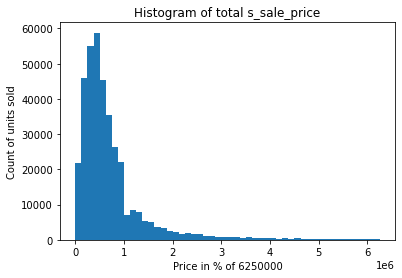

In [521]:
# Histogram of the sales vs 
def hist_col(data, col, b):
    data99_max = data[data[col] <= np.percentile(data[col],99)][col].max()
    plt.hist(data[col],bins=b, range=(0, np.percentile(data[col],99)))
    plt.xlabel(f'Price in % of {data99_max}')
    plt.ylabel("Count of units sold")
    plt.title('Histogram of total ' + col)
    plt.show()
hist_col(data, 's_sale_price', 50)

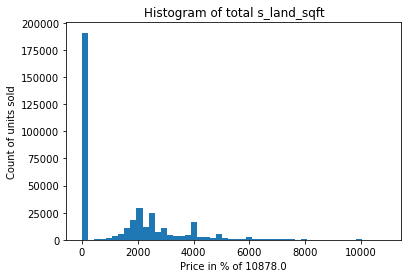

In [522]:
hist_col(data, "s_land_sqft", 50)

In [523]:
# Number of 0 values in sales s_land_sqft
print(f'Zero values for sqft of land in Sales: {((data.s_land_sqft) == 0).sum()}')
# Number of 0 values in valuation lotfront or lotdepth
print(f'Zero values for sqft in Valuation: {((data.v_ltfront * data.v_ltdepth) == 0).sum()}')
# Where we have 0 values in either sales or valuation
miss_area = data[(data.s_land_sqft == 0) & ((data.v_ltfront * data.v_ltdepth) == 0)]
print(f'Total number of missing values for area that we can not impute {miss_area.shape[0]}')

Zero values for sqft of land in Sales: 190904
Zero values for sqft in Valuation: 64442
Total number of missing values for area that we can not impute 62059


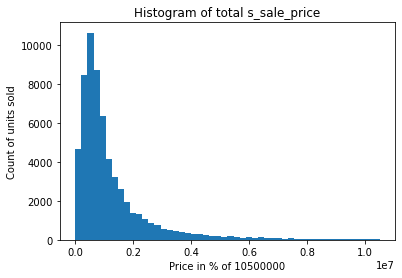

In [524]:
# Histogram of sales with missing values for square footage
hist_col(miss_area, 's_sale_price', 50)

## Imputing the missing Area

In [525]:
# Remove all rows that we can not impute
data.drop(axis =0, index = miss_area.index, inplace=True)
print(f'Check that right number rows dropped. Original - New: {num_rows - data.shape[0]} Non imputable: {miss_area.shape[0]}')

Check that right number rows dropped. Original - New: 62059 Non imputable: 62059


In [526]:
# Get rid of the original index values that are no longer applicable
data = data.reset_index(drop=True)

In [527]:
data["prod_vf_vd"] = data.v_ltfront * data.v_ltdepth
def create_imputed_land_area(row):
    if row["s_land_sqft"] == 0:
        return row["prod_vf_vd"]
    else:
        return row["s_land_sqft"]
data["imputed_land_area"] = data.apply(lambda row: create_imputed_land_area(row), axis=1)

In [528]:
# Sanity check that there are no zero values for area
print(f'Count of missing area values:{(data.imputed_land_area == 0).sum()}')
# Compare the square footage of the imputed area and product of v_ltfront and v_ltdepth
np.abs((data.imputed_land_area - data.prod_vf_vd)).sum()/(data.imputed_land_area.sum())

Count of missing area values:0


0.022250141536719854

In [529]:
drop = ["s_land_sqft", "v_ltfront", "v_ltdepth", "prod_vf_vd"]
data.drop(drop, axis =1, inplace=True)

## Imputing Total Units

In [530]:
data[data.s_total_units == 0].groupby(data.s_building_class_at_sale).count()

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,s_bbl,v_stories,v_fullval,v_latitude,v_longitude,v_nta,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
s_building_class_at_sale,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1,10,10,10,10,10,10,10,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
A2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,

It makes sense that cooperatives would have no information on the number of units available within the apartment as the building is owned by everyone as a whole and it is then split up amongst the residents. As a result all of the cooperatives will not have total

In [531]:
coops = data[(data.s_building_class_at_sale == "C6") 
         | (data.s_building_class_at_sale == "D0") 
         | (data.s_building_class_at_sale == "D4")]

coops.shape[0]

113948

In [532]:
data2 = data.copy()

In [533]:
coops.index.to_numpy()

array([    21,     22,     23, ..., 317067, 317068, 317166])

In [534]:
coops_index = coops.index.to_numpy()

In [535]:
data.at[coops_index , "s_total_units"] = 1
(data.s_total_units == 0).sum()

422

In [536]:
# The remaining values were errors in recording so we will drop these rows.
miss_tot_units = data[data.s_total_units == 0].index.to_numpy()
data.drop(axis =0, index = miss_tot_units, inplace=True)
data = data.reset_index(drop=True)

This is why we're going to remove all coop values that are larger than 80,000,000. Because we are not focused on buildings.
https://ny.curbed.com/2014/9/4/10051426/71-3m-park-avenue-pad-is-nycs-most-expensive-co-op-ever

In [537]:
large_coop = coops[coops.s_sale_price > 80000000].index.to_numpy()
data.drop(axis = 0, index = large_coop, inplace=True)
data = data.reset_index(drop=True)

In [538]:
# The median of sales price 
print(data.s_sale_price.median())
# The median of the valuation assessment
print(data.v_fullval.median())
# The median difference between the sales price and the valuation assessment
print(np.abs(data.s_sale_price - data.v_fullval).median())

485000.0
692000.0
300400.0


In [539]:
# Double check that there are no missing values anywhere
data.columns[data.isnull().sum() != 0]

Index(['v_stories', 'v_latitude', 'v_longitude', 'v_nta'], dtype='object')

## Last Imputation of Missing Values

In [540]:
miss_v_stories = data.v_stories[data.v_stories.isnull()].index.to_numpy()
len(miss_v_stories)

1570

In [541]:
miss_v_stories

array([   642,    787,    834, ..., 316768, 316769, 316770])

In [542]:
data.at[miss_v_stories, "v_stories"] = 1

There are only 1591 rows where we having missing number of stories. For now we can leave this data in and just set the value of v_stories in these rows to 0.

In [543]:
miss_v_latitude = data.v_latitude[data.v_latitude.isnull()].index.to_numpy()
miss_v_longitude = data.v_longitude[data.v_longitude.isnull()].index.to_numpy()
print(len(miss_v_latitude))
print((miss_v_latitude - miss_v_longitude).sum())
data.drop(axis =0, index = miss_v_latitude, inplace=True)

1708
0


In [544]:
# Get rid of the original index values that are no longer applicable
data = data.reset_index(drop=True)

It looks like there are 1776 rows with missing latitude longitude pairs and there in every row that is missing either lat or lon it is missing both values. We will drop these rows as we wish to have the crime data engineered using these coordinates.

In [545]:
len(data.v_nta[data.v_nta.isnull()])

0

In [547]:
# Find the categorical columns to convert
cat_col = data.select_dtypes(exclude=['int64', 'float']).columns.to_list()
print(cat_col)

# s_bbl is actually not needed anymore so we can remove it from the list and the dataframe
cat_col.remove('s_bbl')
data.drop(columns = ['s_bbl'], inplace=True)
data = data.reset_index(drop=True)
print(cat_col)

['s_building_class_at_sale', 's_bbl', 'v_nta']
['s_building_class_at_sale', 'v_nta']


Feature engineering the Datetime variable to convert it to numerical https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96#:~:text=Dates%20and%20times%20are%20rich,turn%20them%20into%20numerical%20data.

In [548]:
data.describe()

,s_borough,s_zipcode,s_total_units,s_year_built,s_sale_price,v_stories,v_fullval,v_latitude,v_longitude,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
count,315069.000000,315069.000000,315069.000000,315069.000000,3.150690e+05,315069.000000,3.150690e+05,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,3.150690e+05,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069.000000,315069

In [549]:
data.to_pickle(above + 'post_eda_pre_ordinal.pkl')

In [550]:
# We have to use ordinal encoding to transform the categorical to numerical
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

# Create transformation function, input data and list of categorical columns, returns replace map
def ordinal_map(df, cols):
    replace_map = {}
    encoder = OrdinalEncoder()
    encoder.fit(data[cols])
    cats = encoder.categories_
    for i in range(len(cols)):
        c =  data[cat_col[i]].unique().tolist()        
        o = list(map(lambda x:[x], c)) 
        result = encoder.fit_transform(o)
        cat = cats[i]
        replace_map[cols[i]] = {k: v for k,v in zip(cats[i], [x[0] for x in result.tolist()])}
    return replace_map

r_map = ordinal_map(data, cat_col)
data.replace(r_map, inplace=True)

In [551]:
r_map

{'s_building_class_at_sale': {'A0': 1.0,
  'A1': 10.0,
  'A2': 30.0,
  'A3': 13.0,
  'A4': 5.0,
  'A5': 9.0,
  'A6': 20.0,
  'A7': 2.0,
  'A9': 11.0,
  'B1': 26.0,
  'B2': 29.0,
  'B3': 24.0,
  'B9': 12.0,
  'C0': 3.0,
  'C1': 18.0,
  'C2': 8.0,
  'C3': 7.0,
  'C5': 25.0,
  'C6': 16.0,
  'D0': 0.0,
  'D4': 4.0,
  'D6': 19.0,
  'G0': 27.0,
  'R1': 23.0,
  'R2': 17.0,
  'R3': 6.0,
  'R4': 34.0,
  'R6': 15.0,
  'S0': 28.0,
  'S1': 31.0,
  'S2': 32.0,
  'S3': 14.0,
  'S4': 33.0,
  'S9': 21.0,
  'V0': 22.0,
  'Z0': 35.0},
 'v_nta': {'Allerton-Pelham Gardens': 32.0,
  "Annadale-Huguenot-Prince's Bay-Eltingville": 56.0,
  'Arden Heights': 184.0,
  'Astoria': 35.0,
  'Auburndale': 11.0,
  'Baisley Park': 120.0,
  'Bath Beach': 13.0,
  'Battery Park City-Lower Manhattan': 0.0,
  'Bay Ridge': 20.0,
  'Bayside-Bayside Hills': 150.0,
  'Bedford': 177.0,
  'Bedford Park-Fordham North': 130.0,
  'Bellerose': 145.0,
  'Belmont': 38.0,
  'Bensonhurst East': 53.0,
  'Bensonhurst West': 111.0,
  'Boroug

In [552]:
data.head(5)

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,v_stories,v_fullval,v_latitude,v_longitude,v_nta,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
0,2,10458.0,1.0,1910.0,10.0,329000,2.0,365000,40.856635,-73.892647,85.0,3.391905,4.755,167.18963,141.525,221.187,222.803,0.168387,3.156842,311023.0,15712.754,1283.124286,9.1,57021.0,0.02907,0.008697,-0.006628,-0.003766,0.003243,0.002069,-0.080986,0.04171,0.000531,-0.000803,0.032955,-0.021505,-0.001289,861146,137783.36,0.16,126588.462,0.147,237676.296,0.276,145533.674,0.169,63724.804,0.074,95587.206,0.111,54252.198,0.063,1392002.0,342432.492,0.246,503904.724,0.362,13920.02,0.01,55680.08,0.04,2784.004,0.002,524784.754,0.377,512320,30739.2,0.06,169577.92,0.331,173164.16,0.338,112710.4,0.22,17418.88,0.034,9221.76,0.018,88816,8259.88

In [553]:
# Remove this after the feature engineering is done, if any
data.drop(columns = ['v_latitude', 'v_longitude'], inplace=True)

In [554]:
data = data.reset_index(drop=True)
data.to_pickle(above + 'post_eda.pkl')

# PCA

In [598]:
data = pd.read_pickle(above + 'post_eda.pkl')

In [599]:
data = data.sample(n = 1000)

In [601]:
#normed_data = (data - data.min()) / data.to_numpy().ptp(0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = data.loc[:, data.columns != 's_sale_price']  #independent columns
y = data.loc[:, data.columns == 's_sale_price']    #target column sales price
scaler.fit(data.loc[:, data.columns != 's_sale_price'])
scaled_data = scaler.transform(data.loc[:, data.columns != 's_sale_price'])

In [602]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [603]:
scaled_data

array([[-0.08388523,  0.57990666,  0.95359757, ..., -0.25606116,
         1.0325098 , -0.30545973],
       [-0.08388523,  0.63048506, -0.62520636, ...,  1.41144037,
         1.1134234 ,  0.02469659],
       [-0.87525532, -0.76584009,  2.5324015 , ..., -0.31574529,
        -0.18019525, -0.30714145],
       ...,
       [ 0.70748486,  0.98995299, -0.62520636, ..., -0.88538363,
        -0.26410565, -0.29929789],
       [ 0.70748486,  0.96285741,  0.95359757, ..., -0.49682776,
        -0.31971294, -0.30243262],
       [ 0.70748486,  0.87253884, -0.62520636, ..., -0.37380536,
        -0.16387934,  1.51753056]])

In [604]:
data.cov()

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,v_stories,v_fullval,v_nta,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
s_borough,1.598362,4.010166e+02,0.049073,31.133550,2.660979,-3.561400e+05,-4.006526,-7.279744e+06,1.389992,0.002486,0.005854,0.490183,0.861976,0.299787,0.441812,0.023669,0.008068,2.013549e+02,3.782084e+01,1.577901e+01,-0.073760,1.184284e+02,0.002882,0.001068,0.000245,0.000114,-0.000022,1.040199e-05,-0.002568,-0.001055,-0.000004,-0.000116,0.000106,-0.001875,-0.000054,-3.858265e+04,3.037561e+03,-0.003916,-1.601604e+02,-0.001968,6.224216e+04,0.063970,1.479568e+04,0.020103,1.711954e+04,0.015865,-5.629288e+04,-0.037587,-7.933046e+04,-0.056427,-3.046751e+04,-5.793312e+04,0.025439,-3.717572e+04,-0.030964,-3.821769e+03,-0.002885,1.033868e+05,0.044363,4.337439

In [605]:
data

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,v_stories,v_fullval,v_nta,m_10yr_treasury_constant_maturity_rate,m_30yr_fixed_rate_mortgage_avg_in_us,m_case_shiller_ny_home_price_index,m_case_shiller_us_national_home_price_index,m_consumer_price_index,m_core_cpi,m_effective_fed_funds_rate,m_inflation_rate,m_population_level,m_real_gross_domestic_product,m_sp500_index,m_unemployment_rate,m_us_real_median_household_income,m_10yr_treasury_constant_maturity_rate_%chg,m_30yr_fixed_rate_mortgage_avg_in_us_%chg,m_case_shiller_ny_home_price_index_%chg,m_case_shiller_us_national_home_price_index_%chg,m_consumer_price_index_%chg,m_core_cpi_%chg,m_effective_fed_funds_rate_%chg,m_inflation_rate_%chg,m_population_level_%chg,m_real_gross_domestic_product_%chg,m_sp500_index_%chg,m_unemployment_rate_%chg,m_us_real_median_household_income_%chg,d_pop_25_years_and_over,d_less_than_9th_grade,d_less_than_9th_grade_pct,d_9th_to_12th_grade_no_diploma,d_9th_to_12th_grade_no_diploma_pct,d_high_school_graduate,d_high_school_graduate_pct,d_some_college_no_degree,d_some_college_no_degree_pct,d_associates_degree,d_associates_degree_pct,d_bachelors_degree,d_bachelors_degree_pct,d_graduate_or_professional_degree,d_graduate_or_professional_degree_pct,d_total_population,d_white_population,d_white_population_pct,d_black_or_african_american_population,d_black_or_african_american_population_pct,d_american_indian_and_alaska_native_population,d_american_indian_and_alaska_native_population_pct,d_asian_population,d_asian_population_pct,d_native_hawaiian_and_other_pacific_islander_population,d_native_hawaiian_and_other_pacific_islander_population_pct,d_some_other_race_population,d_some_other_race_population_pct,d_total_housing_units,d_no_bedroom_units,d_no_bedroom_units_pct,d_1_bedroom_units,d_1_bedroom_units_pct,d_2_bedroom_units,d_2_bedroom_units_pct,d_3_bedroom_units,d_3_bedroom_units_pct,d_4_bedroom_units,d_4_bedroom_units_pct,d_5_bedroom_units,d_5_bedroom_units_pct,d_owner_occupied_units,d_units_less_than_50000,d_units_less_than_50000_pct,d_units_from_50000_to_99999,d_units_from_50000_to_99999_pct,d_units_from_100000_to_149999,d_units_from_100000_to_149999_pct,d_units_from_150000_to_199999,d_units_from_150000_to_199999_pct,d_units_from_200000_to_299999,d_units_from_200000_to_299999_pct,d_units_from_300000_to_499999,d_units_from_300000_to_499999_pct,d_units_from_500000_to_999999,d_units_from_500000_to_999999_pct,d_units_1000000_or_more,d_units_1000000_or_more_pct,d_median_housing_price,d_total_households,d_households_less_than_10000,d_households_less_than_10000_pct,d_households_from_10000_to_14999,d_households_from_10000_to_14999_pct,d_households_from_15000_to_24999,d_households_from_15000_to_24999_pct,d_households_from_25000_to_34999,d_households_from_25000_to_34999_pct,d_households_from_35000_to_49999,d_households_from_35000_to_49999_pct,d_households_from_50000_to_74999,d_households_from_50000_to_74999_pct,d_households_from_75000_to_99999,d_households_from_75000_to_99999_pct,d_households_from_100000_to_149999,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
278692,3,11207.0,2.0,1910.0,29.0,849900,2.0,571000,21.0,2.912381,4.5700,198.170185,202.420,251.176,257.422,1.819667,2.179928,326847.0,18719.697667,2754.352857,4.0,66148.583333,-0.021263,-0.003489,0.000922,0.003555,0.002139,0.001420,0.070392,-0.023531,0.000453,0.001748,0.019241,0.052632,0.005547,1785323,153537.778,0.086,142825.840,0.080,460613.334,0.258,230306.667,0.129,103548.734,0.058,415980.259,0.233,278510.388,0.156,2582830.0,1203598.780,0.466,865248.050,0.335,18079.810,0.007,346099.220,0.134,2582.830,0.001,247951.680,0.096,1053667,63220.020,0.060,291865.759,0.277,363515.115,0.345,233914.074,0.222,67434.688,0.064,34771.011,0.033,296235,6220.935,0.0

In [606]:
eigval, eigvec = np.linalg.eig(data.cov())

In [607]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 119)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
scaled_data.shape

(1000, 119)

In [608]:
x_pca.shape

(1000, 119)

In [609]:
pca.singular_values_

array([1.81159251e+02, 1.59264501e+02, 1.32441935e+02, 1.03125822e+02,
       8.21998856e+01, 5.39617568e+01, 5.12599007e+01, 4.16443900e+01,
       4.05657972e+01, 3.73335859e+01, 3.51005359e+01, 3.34725059e+01,
       3.28538776e+01, 3.24115644e+01, 3.14575841e+01, 3.03987915e+01,
       2.95295311e+01, 2.76686397e+01, 2.72819439e+01, 2.65480657e+01,
       2.56809874e+01, 2.48962445e+01, 2.42253848e+01, 2.36880279e+01,
       2.21992895e+01, 2.06326636e+01, 1.96585313e+01, 1.74198384e+01,
       1.66832904e+01, 1.59120260e+01, 1.50880357e+01, 1.36586456e+01,
       1.12494679e+01, 1.04032282e+01, 1.01151821e+01, 9.64511320e+00,
       9.33695588e+00, 8.72487933e+00, 7.97429125e+00, 7.65988236e+00,
       7.12780607e+00, 6.56373928e+00, 5.98724002e+00, 5.51453298e+00,
       5.24185752e+00, 5.09664620e+00, 4.62620104e+00, 4.33446703e+00,
       4.00141438e+00, 3.91424489e+00, 3.68699900e+00, 3.34410684e+00,
       3.27719697e+00, 3.04324998e+00, 2.98456789e+00, 2.82151573e+00,
      

In [610]:
principal_df = pd.DataFrame(data = x_pca, columns = ["Principal Component " + str(x) for x in range(1, 120)])

In [611]:
#print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [612]:
pca.explained_variance_ratio_[0:20].sum()

0.9488422066126933

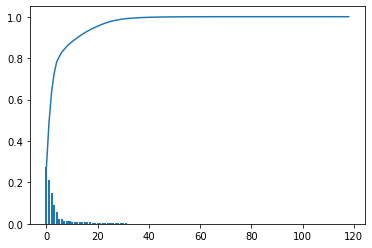

In [613]:
# plt.subplots=(1,2,1)
plt.bar(np.arange(0,119),pca.explained_variance_ratio_[0:119])
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(0,119),cumsum)

Maybe I should be using this for normalizing the data instead of taking the absoulte value of the dataframe to get rid of negative values https://stats.stackexchange.com/questions/341332/how-to-scale-for-selectkbest-for-feature-selection

Following the workflow from the following notebook: https://machinelearningmastery.com/feature-selection-for-regression-data/

In [614]:
# split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [61]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)
return X_train_fs, X_test_fs, fs

In [638]:
data = pd.read_pickle(above + 'post_eda.pkl')
data = data[['d_pop_25_years_and_over',
       'm_case_shiller_ny_home_price_index_%chg',
       'm_us_real_median_household_income_%chg', 'c_count',
       'm_inflation_rate_%chg', 's_total_units', 'm_sp500_index_%chg',
       'm_real_gross_domestic_product_%chg', 's_building_class_at_sale',
       'm_10yr_treasury_constant_maturity_rate',
       'm_30yr_fixed_rate_mortgage_avg_in_us', 's_zipcode',
       'd_households_from_10000_to_14999_pct', 'v_stories', 'v_nta',
       'm_sp500_index', 'd_high_school_graduate_pct', 's_year_built',
       'imputed_land_area', 'v_fullval', 's_sale_price']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = data.loc[:, data.columns != 's_sale_price']  #independent columns
y = data.loc[:, data.columns == 's_sale_price']    #target column sales price
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y)

In [639]:
# data = pd.read_pickle(above + 'post_eda.pkl')
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = data.loc[:, data.columns != 's_sale_price']  #independent columns
# y = data.loc[:, data.columns == 's_sale_price']    #target column sales price
# scaler.fit(data.loc[:, data.columns != 's_sale_price'])
# scaled_data = scaler.transform(data.loc[:, data.columns != 's_sale_price'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

from sklearn.ensemble import GradientBoostingRegressor
# Create the model
gradient_boosted = GradientBoostingRegressor()

# Fit the model on the training data
gradient_boosted.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
predictions = gradient_boosted.predict(X_test)

# Evaluate the model
mae = np.mean(abs(predictions - y_test.values.ravel()))

print('Gradient Boosted Performance on the test set: MAE = %0.4f' % mae)

Gradient Boosted Performance on the test set: MAE = 324801.9733


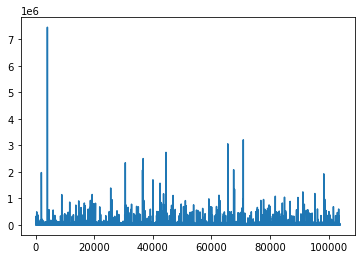

In [661]:
plt.plot(np.arange(0, len(y_test.values.ravel())),(np.abs(predictions - y_test.values.ravel())/(y_test.values.ravel())))

In [662]:
np.abs(predictions - y_test.values.ravel()).max()

161269690.47013235